In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import glob
import pickle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from models_ml_dl import deep_learning_model as dl_models
from visualization import model_evaluation as eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Preparation

In [53]:
# hourly data

journey_hourly_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2016.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2017.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2018.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_train_orig = pd.concat([journey_hourly_16, journey_hourly_17, journey_hourly_18])
journey_test_orig = journey_hourly_19.copy()

# remove start_data and demand column
journey_train = journey_train_orig.drop(columns=['start_date', 'demand'])
journey_test = journey_test_orig.drop(columns=['start_date', 'demand'])


In [54]:
# min max scaling

# initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit the scaler using the training data and transform the training and test data
journey_train_scaled = scaler.fit_transform(journey_train)
journey_test_scaled = scaler.transform(journey_test)

# convert back to DataFrame
journey_train_scaled = pd.DataFrame(journey_train_scaled, columns=journey_train.columns)
journey_test_scaled = pd.DataFrame(journey_test_scaled, columns=journey_test.columns)

# add the target feature back
journey_train_scaled['demand'] = journey_train_orig['demand'].values
journey_test_scaled['demand'] = journey_test_orig['demand'].values

In [55]:
lookback = 24
X_train, Y_train, X_test, Y_test = dl_models.create_train_test_data(journey_train_scaled, journey_test_scaled, lookback)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(314724, 24, 105) (314724,)
(104772, 24, 105) (104772,)


In [51]:
print(np.array(journey_train_scaled['demand'][0:100]))

[ 60.  69.  14.  22.  11.  26.  57.  54.  31.  12. 423.   0.  59.  52.
  21.  23.  16.  31.  89.  87.  67.  21. 192.   0.  28.  23.  21.  14.
  15.  42.  24.  51.  44.  23.  96.   0.  21.  19.  18.  21.  15.  28.
  23.  21.  43.  19.  66.   0.  26.   4.  13.   7.  10.  25.  30.  26.
  31.  14.  33.   0.  23.   7.  16.   9.   6.  10.   6.  12.  25.   6.
  33.   0.   7.   6.   7.   5.   9.  26.  11.   4.  22.   2.  21.   0.
  10.   5.  12.   5.   5.  10.   3.   6.  15.   7.  18.   0.   6.   4.
   4.   8.]


In [52]:
np.set_printoptions(threshold=np.inf)
print(Y_train[:100]) 

[28. 23. 21. 14. 15. 42. 24. 51. 44. 23. 96.  0. 21. 19. 18. 21. 15. 28.
 23. 21. 43. 19. 66.  0. 26.  4. 13.  7. 10. 25. 30. 26. 31. 14. 33.  0.
 23.  7. 16.  9.  6. 10.  6. 12. 25.  6. 33.  0.  7.  6.  7.  5.  9. 26.
 11.  4. 22.  2. 21.  0. 10.  5. 12.  5.  5. 10.  3.  6. 15.  7. 18.  0.
  6.  4.  4.  8.  6. 18.  4.  7. 12.  3. 45.  0.  4.  7.  3. 17.  3. 21.
  8. 20. 24.  3. 54.  0. 26. 25. 15. 12.]


In [5]:
num_rows_to_cut = journey_test_orig.shape[0] - Y_test.shape[0]
print(num_rows_to_cut)
journey_test_orig_t = journey_test_orig.iloc[num_rows_to_cut:, :]
print(journey_test_orig_t.shape, Y_test.shape)


96
(104700, 106) (104700,)


In [ ]:
journey_test_orig['demand'].tail(12)

0    73.0
1    99.0
2    14.0
3    19.0
4     6.0
Name: demand, dtype: float64

In [7]:
Y_test

array([ 6.,  6.,  7., ..., 31.,  5., 28.])

### LSTM

In [56]:
lstm_model = dl_models.create_lstm(X_train, units=30)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 30)            16320     
                                                                 
 lstm_4 (LSTM)               (None, 24, 30)            7320      
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 30,991
Trainable params: 30,991
Non-trainable params: 0
_________________________________________________________________


In [57]:
# fitting and predicting

lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_history = lstm_model.fit(X_train, Y_train, epochs = 1, batch_size = 32, 
                    validation_split= 0.2, 
                    callbacks = EarlyStopping(monitor='val_loss', patience = 5))

lstm_pred = lstm_model.predict(X_test)


3275/3275 [==============================] - 22s 6ms/step


In [153]:
# save model and history
lstm_model.save('../models/lstm_model.h5')

with open('../models/lstm_history.pkl', 'wb') as f:
    pickle.dump(lstm_history.history, f)

In [58]:
# evaluation
mae = mean_absolute_error(Y_test, lstm_pred)
rmse = mean_squared_error(Y_test, lstm_pred, squared=False)
r_squared = r2_score(Y_test, lstm_pred)

print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

MAE:  33.949553958029696
RMSE:  97.54210095612679
R2:  0.49906264585351146


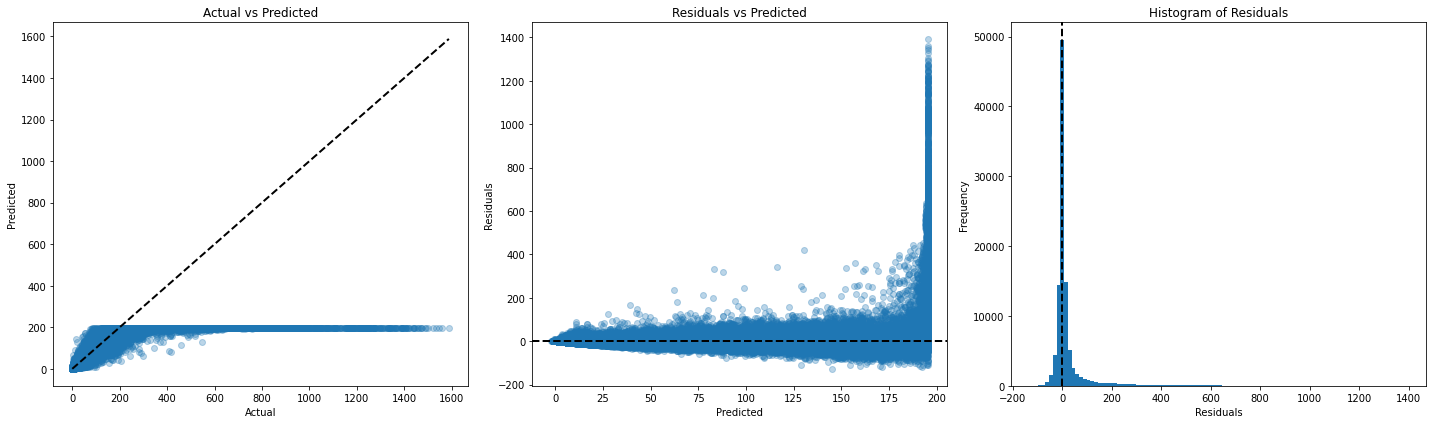

In [59]:
eval.evaluation_vis(Y_test, lstm_pred.reshape(-1))

0


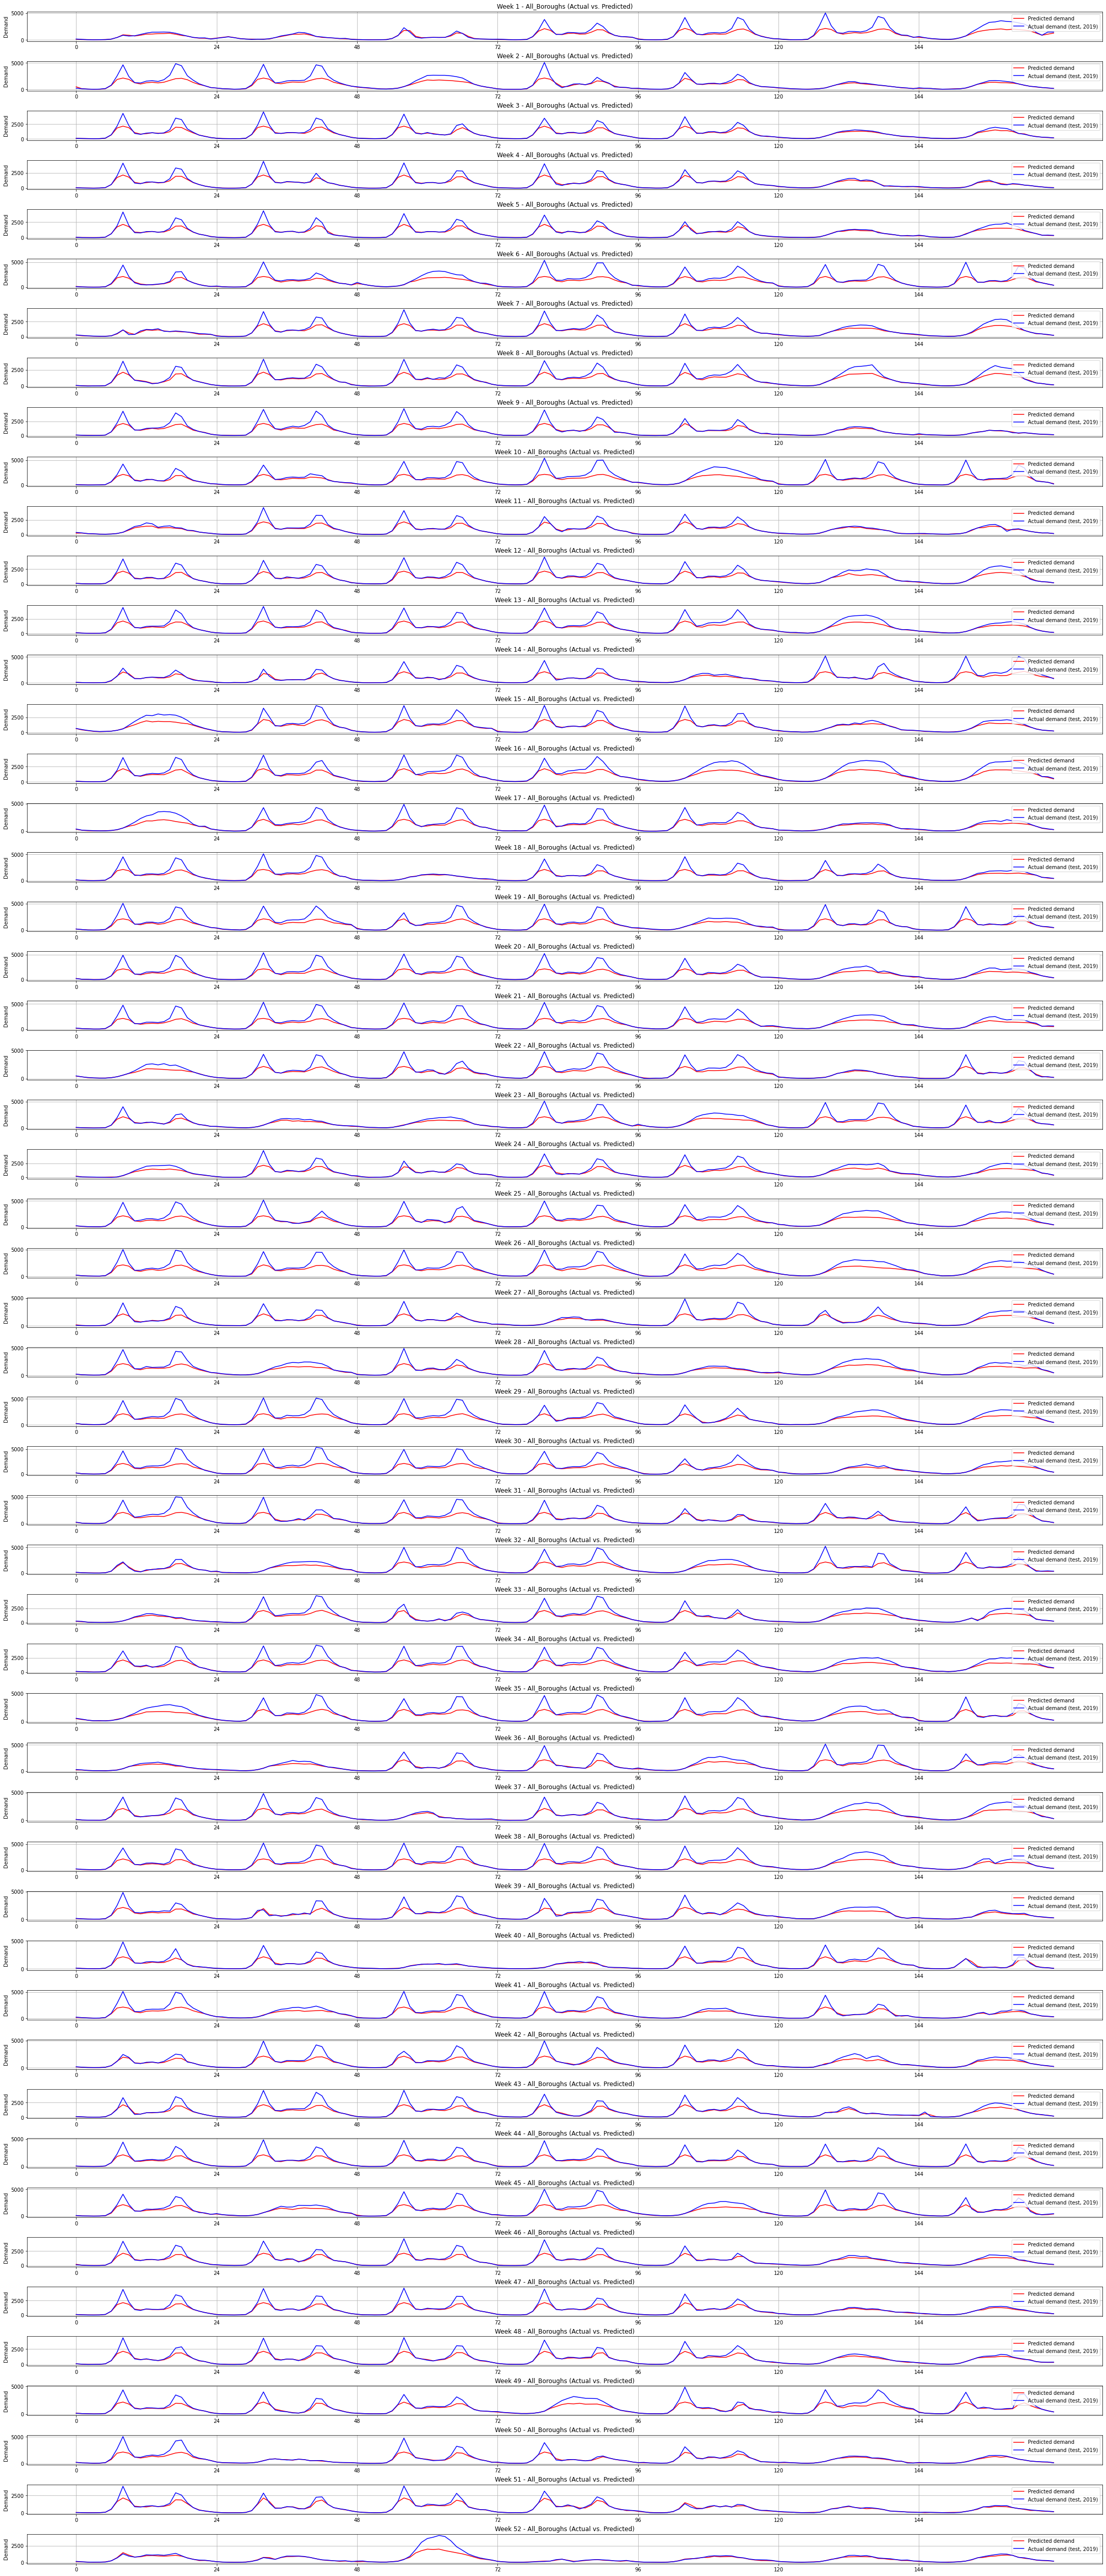

In [63]:
# visualisation: pred vs actual

num_rows_to_cut = journey_test_orig.shape[0] - Y_test.shape[0]
print(num_rows_to_cut)
journey_test_orig = journey_test_orig.iloc[num_rows_to_cut:, :]

eval.evaluation_actual_vs_predicted_hourly(Y_test, lstm_pred, journey_test_orig, 'All_Boroughs', 'model_lstm')


In [ ]:
# visualisation: pred vs actual per borough
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(Y_test, lstm_pred, journey_test_orig, borough, 'model_lstm')

### Transformer

In [12]:
# train model
tr_model = dl_models.Transformer()
tr_model.train(X_train, Y_train, epochs=10)

# save model
tr_model.model.save('../models/tranformer_model.h5')

# predict
tr_pred = tr_model.predict(X_test)

Epoch 1/10
9800/9800 [==============================] - 19890s 2s/step - loss: 0.0493
Epoch 2/10
9800/9800 [==============================] - 15335s 2s/step - loss: 0.0189
Epoch 3/10
  20/9800 [..............................] - ETA: 1:42:15 - loss: 0.0168

KeyboardInterrupt: 

In [ ]:
# transform to original scale
tr_pred_inv, Y_test_inv = dl_models.transform_to_original_sclae(total_df, tr_pred, Y_test, input_data, scaler)

In [ ]:
# evaluation
mae = mean_absolute_error(Y_test_inv, tr_pred_inv)
rmse = mean_squared_error(Y_test_inv, tr_pred_inv, squared=False)
r_squared = r2_score(Y_test_inv, tr_pred_inv)

print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

Evaluation
MAE:  5.987470258906309
RMSE:  22.99890016918649
R2:  0.9187948549522943


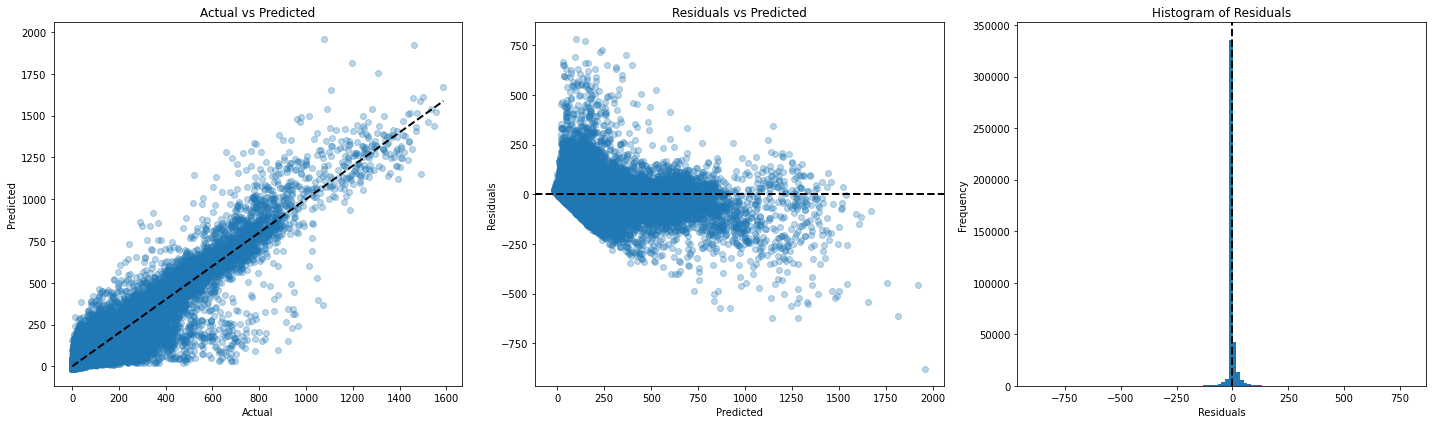

In [ ]:
# evaluation visualisation
eval.evaluation_vis(Y_test_inv, tr_pred_inv)

In [ ]:
# visualisation: pred vs actual
eval.evaluation_actual_vs_predicted(Y_test_inv, tr_pred_inv, journey_test_orig, 'All_Boroughs', 'model_transformer')

In [ ]:
# visualisation: pred vs actual per borough
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(Y_test_inv, tr_pred_inv, journey_test_orig, borough, 'model_transformer')